# Sound Event Detection with Depthwise Separable and Dilated Convolutions

## 1 Import major libraries

In [1]:
import numpy as np
import plaidml.keras
import os
plaidml.keras.install_backend()
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

from keras import backend as K
print(K)

import keras
from keras.preprocessing.image import ImageDataGenerator

print("Keras version %s" %keras.__version__)

<module 'plaidml.keras.backend' from 'E:\\anaconda3\\envs\\plaidML\\lib\\site-packages\\plaidml\\keras\\backend.py'>
Keras version 2.2.4


## 2 Load meta file (onset, offset, labels)

In [26]:
import pandas as pd
meta = pd.read_csv('E:\\Xception\\TUT-SED-synthetic-2016\\meta.txt', delimiter = "\t", header=None)
meta.columns = ["file", "drop1", "onset", "offset", "label", "drop2"]
# delete not useful columns
meta = meta.drop(columns=["drop1", "drop2"])

## 3 Data analysis

### Labels distribution in dataset

In [27]:
# Class distribution
meta['label'].value_counts()

footsteps            8302
horsewalk            6603
bird_singing         6079
baby_crying          3342
dog_barking          3145
gun_shot             1581
crowd_applause       1400
cat_meowing           885
motorcycle            824
thunder               774
glass_smash           693
crowd_cheering        613
alarms_and_sirens     571
mixer                 547
rain                  511
bus                   456
Name: label, dtype: int64

### Audio properties 

In [28]:
import struct
import re

directory = 'E:\\Xception\\TUT-SED-synthetic-2016\\audio\\'

# support to read file header and return audio properties
def read_header(filename):
    wave = open(filename,"rb")
    riff = wave.read(12)
    fmat = wave.read(36)
    num_channels_string = fmat[10:12]
    num_channels = struct.unpack('<H', num_channels_string)[0]
    sample_rate_string = fmat[12:16]
    sample_rate = struct.unpack("<I",sample_rate_string)[0]
    bit_depth_string = fmat[22:24]
    bit_depth = struct.unpack("<H",bit_depth_string)[0]
    return (num_channels, sample_rate, bit_depth)

# Read every file header to collect audio properties
audiodata = []
for index, row in meta.iterrows():
    cat = str(row["label"])
    name = str(row["file"])
    i = name[:-4]
    i = i[33:]
    file_name = directory+'TUT-SED-synthetic-2016-mix-'+str(i)+'.wav'
    audio_props = read_header(file_name)
    duration = row['offset'] - row['onset']
    audiodata.append((name, cat, duration) + audio_props)

# Convert into a Pandas dataframe
audiodatadf = pd.DataFrame(audiodata, columns=['file', 'class', 'duration', 'channels','sample_rate','bit_depth'])

### Audio duration visualization

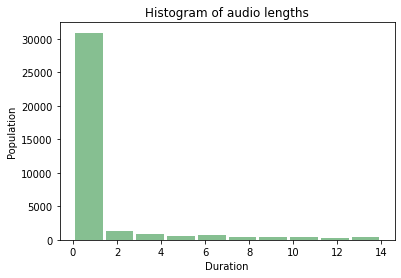

In [29]:
import matplotlib.pyplot as plt

plt.hist(audiodatadf['duration'], rwidth=0.9, color='#86bf91')

plt.xlabel('Duration')
plt.ylabel('Population')
plt.title('Histogram of audio lengths')
plt.grid(False)
plt.show()

### Audio channels

In [30]:
print("Audio channels:\n")
print(audiodatadf.channels.value_counts(normalize=True))

Audio channels:

1    1.0
Name: channels, dtype: float64


### Bit depth

In [31]:
print("Bit depths:\n")
print(audiodatadf.bit_depth.value_counts(normalize=True))

Bit depths:

32    1.0
Name: bit_depth, dtype: float64


### Sample rate

In [32]:
print("Sample rates:\n")
print(audiodatadf.sample_rate.value_counts(normalize=True))

Sample rates:

44100    1.0
Name: sample_rate, dtype: float64


## 4 Data Preprocessing

In [3]:
# Load various imports 
import pandas as pd
#import librosa.display
import librosa

directory = 'E:\\Xception\\TUT-SED-synthetic-2016\\audio\\'

features = []
num_frames = []

#length of splitted subvectors
length = 1024

# Iterate through each sound file and extract the features 
for i in range(100):
    
    if i%10==0:
        print("processing element ",i)
    
    file_name = directory+'TUT-SED-synthetic-2016-mix-'+str(i)+'.wav'
        
    # load single audio file
    audio, sr = librosa.load(file_name, res_type='kaiser_fast')
    
    # extract mfcc features with 20ms frame and 50% overlap at 22050 Hz
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40, n_fft=440, hop_length=220, n_mels=40)
    
    # save audio number of frames for labelling process
    num_frames.append(mfccs.shape[1])
    
    # create subvectors of length and pad the last to length
    for j in range(int(mfccs.shape[1]/length)+1):
        
        # subdivide in 1024 elements vectors
        feat = mfccs[:,j*length:(j+1)*length]
        
        # last vector need padding
        if feat.shape[1] != length:
            feat = np.pad(feat, pad_width=((0, 0), (0, length-feat.shape[1])), mode='constant')
        
        feat = feat.transpose()
        
        # add new splitted vectors to features list
        features.append(feat)

print('Extracted a total of', len(features), 'features vectors')

processing element  0
processing element  10
processing element  20
processing element  30
processing element  40
processing element  50
processing element  60
processing element  70
processing element  80
processing element  90
Extracted a total of 3376 features vectors


## 5 Data labelling

In [4]:
#labelling matrix creation, this is done due to poliphony of data

import numpy as np

num_classes = meta['label'].nunique()
labels = []

#length of splitted subvectors
length = 1024

# to transform literal label to a numerical value
label_switch = {"alarms_and_sirens" : 0,
                "baby_crying" : 1,
                "bird_singing" : 2,
                "bus" : 3,
                "cat_meowing" : 4,
                "crowd_applause" : 5,
                "crowd_cheering" : 6,
                "dog_barking" : 7,
                "footsteps" : 8,
                "glass_smash" : 9,
                "gun_shot" : 10,
                "horsewalk" : 11,
                "mixer" : 12,
                "motorcycle" : 13,
                "rain" : 14,
                "thunder" : 15,        
}

# iterate over each file and create labels based on meta file
for i in range(100):
    
    if i%10==0:
        print("processing element ",i)
        
    file_name = directory+'TUT-SED-synthetic-2016-mix-'+str(i)+'.wav'

    # initialize matrices with zeros
    single_labels = np.zeros((num_classes, num_frames[i]), dtype=int)

    # extract metadata of single audio file
    query_name = file_name[len('E:\\Xception\\TUT-SED-synthetic-2016\\audio\\'):]
    query_name = 'audio/' + query_name
    subdf = meta.query('file==@query_name')
    
    # populate matrix based on meta file
    # more efficient to do it starting from metafile instead of iterating on the matrix since 
    # features are less than the matrix and there are more zeros than ones at the end of 
    # the process
    onset = np.array(subdf.loc[:, 'onset'])
    offset = np.array(subdf.loc[:, 'offset'])
    labeldf = np.array(subdf.loc[:, 'label'])
    
    for j in range(onset.shape[0]):
        # metadata values are in seconds so transform in 10ms intervals
        start = int(onset[j]*100)
        end = int(offset[j]*100)
        # label based on start and end of the single audio
        for k in range(end-start):
            single_labels[label_switch[labeldf[j]]][k+start] = 1
           
    # create subvectors of length and pad the last to length
    for j in range(int(single_labels.shape[1]/length)+1):
        
        # subdivide in 1024 elements vectors
        lab = single_labels[:,j*length:(j+1)*length]
        
        # last vector need padding
        if lab.shape[1] != length:
            lab = np.pad(lab, pad_width=((0, 0), (0, length-lab.shape[1])), mode='constant')
        
        lab = lab.transpose()
        
        # add new splitted vectors to labels list
        labels.append(lab)


processing element  0
processing element  10
processing element  20
processing element  30
processing element  40
processing element  50
processing element  60
processing element  70
processing element  80
processing element  90


## 6 Preprocessed data manipulation

### Create dataframe to manipulate features and labels

In [5]:
# create empty data frame in pandas
dataframe = pd.DataFrame()

# add features
dataframe['feature']  = features

# add labels
dataframe['class_label']  = labels

print('Total dataset contains', len(dataframe), ' files')

Total dataset contains 3376  files


### Save processed data to pickle file

In [13]:
dataframe.to_pickle('E:\\Xception\\TUT-SED-synthetic-2016\\processed_data_frame_new.pkl')

### Delete unused variable to save RAM

In [ ]:
reset_selective -f features
reset_selective -f labels

### Load processed data from pickle file

In [2]:
import pandas as pd
dataframe = pd.read_pickle('E:\\Xception\\TUT-SED-synthetic-2016\\processed_data_frame_new.pkl')
print("imported", dataframe.shape[0],"elements")

imported 3376 elements


### Process data to input the network 

In [3]:
# Convert features and corresponding classification labels into numpy arrays
X = np.array(dataframe.feature.tolist())
y = np.array(dataframe.class_label.tolist())

# no need to encode labels since they are already in form of one hot encode

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

# delete X to save memory
#reset_selective -f X

### Delete dataframe to save RAM

In [4]:
reset_selective -f dataframe

## 7 Models definitions

### Baseline Model

In [5]:
from keras.models import Model
from keras.layers import SeparableConv2D, ZeroPadding2D, Activation, Dropout, Dense, \
                            Conv2D, MaxPooling2D, Reshape, GRU
from keras.layers.normalization import BatchNormalization
from keras import Input, optimizers

num_rows = X.shape[1]
num_columns = X.shape[2]
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = y.shape[2]

def Net():
    
    # input layer
    inputs = Input(shape=(num_rows, num_columns, num_channels))
    
    # DWS-CNN layer 1
    x = Conv2D(256,kernel_size=(5,5), strides=(1,1), padding='same')(inputs)
    x = Activation('relu')(x)
    # Batch Normalisation before passing it to the next layer
    x = BatchNormalization()(x)
    # Pooling
    x = MaxPooling2D(pool_size=(1,5), padding='same')(x)
    # Dropout
    x = Dropout(0.25)(x)
    
    # DWS-CNN layer 2
    x = Conv2D(256,kernel_size=(5,5), strides=(1,1), padding='same')(x)
    x = Activation('relu')(x)
    # Batch Normalisation before passing it to the next layer
    x = BatchNormalization()(x)
    # Pooling
    x = MaxPooling2D(pool_size=(1,4), padding='same')(x)
    # Dropout
    x = Dropout(0.25)(x)
    
    # DWS-CNN layer 3
    x = Conv2D(256,kernel_size=(5,5), strides=(1,1), padding='same')(x)
    x = Activation('relu')(x)
    # Batch Normalisation before passing it to the next layer
    x = BatchNormalization()(x)
    # Pooling
    x = MaxPooling2D(pool_size=(1,2), padding='same')(x)
    # Dropout
    x = Dropout(0.25)(x)
    
    # reshape data to input recurrent layer
    x = Reshape((1024, 256))(x)
    
    # GRU
    x = GRU(256, return_sequences=True)(x)
        
    # classifier layer
    outputs = Dense(num_labels,activation='sigmoid')(x)
    
    
    # model compilation for training
    adam = optimizers.Adam(lr=0.0001)
    model = Model(inputs, outputs)                            
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=["binary_accuracy"])
    
    return model


# create the model
model = Net()
model.summary()

INFO:plaidml:Opening device "opencl_amd_gfx1010.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1024, 40, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1024, 40, 256)     6656      
_________________________________________________________________
activation_1 (Activation)    (None, 1024, 40, 256)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024, 40, 256)     1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1024, 8, 256)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024, 8, 256)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1024, 8, 256)      1638656   
__________

### Dessed model

In [7]:
from keras.models import Model
from keras.layers import SeparableConv2D, ZeroPadding2D, Activation, Dropout, Dense, \
                            Conv2D, MaxPooling2D, Reshape, GRU
from keras.layers.normalization import BatchNormalization
from keras import Input, optimizers

num_rows = X.shape[1]
num_columns = X.shape[2]
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = y.shape[2]

def Net():
    
    # input layer
    inputs = Input(shape=(num_rows, num_columns, num_channels))
    
    # DWS-CNN layer 1
    x = ZeroPadding2D(padding=(2))(inputs)
    # use valid padding since padding is introduced before due to its special form (maybe it's equal to use same padding?)
    x = SeparableConv2D(256,kernel_size=(5,5), strides=(1,1), padding='valid')(x)
    x = Activation('relu')(x)
    # Batch Normalisation before passing it to the next layer
    x = BatchNormalization()(x)
    # Pooling
    x = MaxPooling2D(pool_size=(1,5), strides=(1,5), padding='valid')(x)
    # Dropout
    x = Dropout(0.25)(x)
    
    # DWS-CNN layer 2
    x = ZeroPadding2D(padding=(2))(x)
    # use valid padding since padding is introduced before due to its special form
    x = SeparableConv2D(256,kernel_size=(5,5), strides=(1,1), padding='valid')(x)
    x = Activation('relu')(x)
    # Batch Normalisation before passing it to the next layer
    x = BatchNormalization()(x)
    # Pooling
    x = MaxPooling2D(pool_size=(1,4), strides=(1,4), padding='valid')(x)
    # Dropout
    x = Dropout(0.25)(x)
    
    # DWS-CNN layer 3
    x = ZeroPadding2D(padding=(2))(x)
    # use valid padding since padding is introduced before due to its special form
    x = SeparableConv2D(256,kernel_size=(5,5), strides=(1,1), padding='valid')(x)
    x = Activation('relu')(x)
    # Batch Normalisation before passing it to the next layer
    x = BatchNormalization()(x)
    # Pooling
    x = MaxPooling2D(pool_size=(1,2), strides=(1,2), padding='valid')(x)
    # Dropout
    x = Dropout(0.25)(x)
    
    x = Reshape((1024, 256))(x)
    
    # GRU
    x = GRU(256, return_sequences=True)(x)
        
    # classifier layer
    outputs = Dense(num_labels,activation='sigmoid')(x)
    
    
    # model compilation for training
    adam = optimizers.Adam(lr=0.0001)
    model = Model(inputs, outputs)                            
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=["binary_accuracy"])
    
    return model


# create the model
model = Net()
model.summary()

INFO:plaidml:Opening device "opencl_amd_gfx1010.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1024, 40, 1)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1028, 44, 1)       0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 1024, 40, 256)     537       
_________________________________________________________________
activation_1 (Activation)    (None, 1024, 40, 256)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024, 40, 256)     1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1024, 8, 256)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024, 8, 256)      0         
__________

### Baseline dilated

In [6]:
from keras.models import Model
from keras.layers import SeparableConv2D, ZeroPadding2D, Activation, Dropout, Dense, \
                            Conv2D, MaxPooling2D, Reshape, Permute
from keras.layers.normalization import BatchNormalization
from keras import Input, optimizers

num_rows = X.shape[1]
num_columns = X.shape[2]
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = y.shape[2]

def Net(dilated_kernel, dilation, dilated_padding):
    
    # input layer
    inputs = Input(shape=(num_rows, num_columns, num_channels))
    
    # DWS-CNN layer 1
    x = Conv2D(256,kernel_size=(5,5), strides=(1,1), padding='same')(inputs)
    x = Activation('relu')(x)
    # Batch Normalisation before passing it to the next layer
    x = BatchNormalization()(x)
    # Pooling
    x = MaxPooling2D(pool_size=(1,5), padding='same')(x)
    # Dropout
    x = Dropout(0.25)(x)
    
    # DWS-CNN layer 2
    x = Conv2D(256,kernel_size=(5,5), strides=(1,1), padding='same')(x)
    x = Activation('relu')(x)
    # Batch Normalisation before passing it to the next layer
    x = BatchNormalization()(x)
    # Pooling
    x = MaxPooling2D(pool_size=(1,4), padding='same')(x)
    # Dropout
    x = Dropout(0.25)(x)
    
    # DWS-CNN layer 3
    x = Conv2D(256,kernel_size=(5,5), strides=(1,1), padding='same')(x)
    x = Activation('relu')(x)
    # Batch Normalisation before passing it to the next layer
    x = BatchNormalization()(x)
    # Pooling
    x = MaxPooling2D(pool_size=(1,2), padding='same')(x)
    # Dropout
    x = Dropout(0.25)(x)
    
    # permute channels with feature 
    x = Permute((1,3,2))(x)
    
    # DIL-CNN 
    x = ZeroPadding2D(padding=(dilated_padding*dilation, 0))(x)
    x = Conv2D(256, kernel_size=dilated_kernel, dilation_rate=(dilation, 1))(x)#, strides=(1,3))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (1,1), strides=(1,3))(x)
    
    # reshape to input the classifier
    x = Reshape((1024, 256*85))(x)
    
    # classifier layer
    outputs = Dense(num_labels,activation='sigmoid')(x)
    
    # model compilation for training
    adam = optimizers.Adam(lr=0.0001)
    model = Model(inputs, outputs)                            
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=["binary_accuracy"])
    
    return model


# create the model
dilated_kernel = (3,3)
dilation = 10
dilated_padding = 1
model = Net(dilated_kernel,dilation,dilated_padding)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1024, 40, 1)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1024, 40, 256)     6656      
_________________________________________________________________
activation_4 (Activation)    (None, 1024, 40, 256)     0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024, 40, 256)     1024      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1024, 8, 256)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024, 8, 256)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1024, 8, 256)      1638656   
__________

### New proposed model (dessed_dilated)

In [20]:
from keras.models import Model
from keras.layers import SeparableConv2D, ZeroPadding2D, Activation, Dropout, Dense, \
                            Conv2D, MaxPooling2D, Reshape, Permute
from keras.layers.normalization import BatchNormalization
from keras import Input, optimizers

num_rows = X.shape[1]
num_columns = X.shape[2]
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = y.shape[2]

def Net(dilated_kernel, dilation, dilated_padding):
    
    # input layer
    inputs = Input(shape=(num_rows, num_columns, num_channels))
    
    # DWS-CNN layer 1
    x = ZeroPadding2D(padding=(2))(inputs)
    # use valid padding since padding is introduced before due to its special form (maybe it's equal to use same padding?)
    x = SeparableConv2D(256,kernel_size=(5,5), strides=(1,1), padding='valid')(x)
    x = Activation('relu')(x)
    # Batch Normalisation before passing it to the next layer
    x = BatchNormalization()(x)
    # Pooling
    x = MaxPooling2D(pool_size=(1,5), strides=(1,5), padding='valid')(x)
    # Dropout
    x = Dropout(0.25)(x)
    
    # DWS-CNN layer 2
    x = ZeroPadding2D(padding=(2))(x)
    # use valid padding since padding is introduced before due to its special form
    x = SeparableConv2D(256,kernel_size=(5,5), strides=(1,1), padding='valid')(x)
    x = Activation('relu')(x)
    # Batch Normalisation before passing it to the next layer
    x = BatchNormalization()(x)
    # Pooling
    x = MaxPooling2D(pool_size=(1,4), strides=(1,4), padding='valid')(x)
    # Dropout
    x = Dropout(0.25)(x)
    
    # DWS-CNN layer 3
    x = ZeroPadding2D(padding=(2))(x)
    # use valid padding since padding is introduced before due to its special form
    x = SeparableConv2D(256,kernel_size=(5,5), strides=(1,1), padding='valid')(x)
    x = Activation('relu')(x)
    # Batch Normalisation before passing it to the next layer
    x = BatchNormalization()(x)
    # Pooling
    x = MaxPooling2D(pool_size=(1,2), strides=(1,2), padding='valid')(x)
    # Dropout
    x = Dropout(0.25)(x)
    
    # permute channels with feature 
    x = Permute((1,3,2))(x)
        
    # DIL-CNN 
    x = ZeroPadding2D(padding=(dilated_padding*dilation, 0))(x)
    x = Conv2D(256, kernel_size=dilated_kernel, dilation_rate=(dilation, 1))(x)#, strides=(1,3))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    #initializer = keras.initializers.Ones()
    #x = Conv2D(256, (1,1), strides=(1,3), kernel_initializer=initializer, trainable = False)(x)
    x = MaxPooling2D(pool_size=(1,3), strides=(1,3), padding='valid')(x)
    
    # reshape to input the classifier
    x = Reshape((1024, 256*84))(x)
    
    # classifier layer
    outputs = Dense(num_labels,activation='sigmoid')(x)
    
    
    # model compilation for training
    adam = optimizers.Adam(lr=0.0001)
    model = Model(inputs, outputs)                            
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=["binary_accuracy"])
    
    return model


# create the model
dilated_kernel = (3,3)
dilation = 10
dilated_padding = 1
model = Net(dilated_kernel,dilation,dilated_padding)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1024, 40, 1)       0         
_________________________________________________________________
zero_padding2d_9 (ZeroPaddin (None, 1028, 44, 1)       0         
_________________________________________________________________
separable_conv2d_7 (Separabl (None, 1024, 40, 256)     537       
_________________________________________________________________
activation_12 (Activation)   (None, 1024, 40, 256)     0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 1024, 40, 256)     1024      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 1024, 8, 256)      0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024, 8, 256)      0         
__________

## 8 Model Training

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime 

num_epochs = 250
# low batch size due to memory maximum dimension, modify if using smaller dataset or larger VRAM
num_batch_size = 1

callbacks = [ModelCheckpoint(filepath='E:\\Xception\\TUT-SED-synthetic-2016\\model-{val_loss:.2f}.h5', 
                               verbose=1, save_best_only=True, monitor="val_loss"),
                EarlyStopping(monitor='val_loss', patience=30)]

start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_split=0.16, verbose=1, callbacks=callbacks)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 2268 samples, validate on 432 samples
Epoch 1/250
2268/2268 [==============================] - 243s 107ms/step - loss: 0.2576 - binary_accuracy: 0.9259 - val_loss: 0.2700 - val_binary_accuracy: 0.9212

Epoch 00001: val_loss improved from inf to 0.26997, saving model to E:\Xception\TUT-SED-synthetic-2016\model-0.27.h5
Epoch 2/250
 599/2268 [======>.......................] - ETA: 3:07 - loss: 0.2618 - binary_accuracy: 0.9250

## 9 Model save and load

### Save model of last epoch

In [12]:
filename = 'E:\\Xception\\TUT-SED-synthetic-2016\\93epochs.h5'
model.save(filename)

### Import saved model

In [ ]:
model2 = keras.models.load_model('E:\\Xception\\TUT-SED-synthetic-2016\\model-0.24.h5')

## 10 Model analysis

### Model evaluation

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=num_batch_size)
print("test loss, test acc:", results)

### Plot training graphs

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Evaluate precision as micro averaging

In [22]:
TP = 0
FP = 0
TN = 0
FN = 0

y_pred = model.predict(x_test, batch_size=8, verbose=1)

for i in range(y_test.shape[0]):
    if i%100 == 0:
        print("processing element ", i)
    for j in range(y_test.shape[1]):
        for k in range(y_test.shape[2]):
            
            test = y_test[i][j][k]
            pred = y_pred[i][j][k]
            
            # binarization of predicted output
            if(pred >= 0.5):
                pred = 1
            else:
                pred = 0

            if(test == 1 and pred == 1):
                TP = TP + 1
            elif(test == 0 and pred == 1):
                FP = FP + 1
            elif(test == 0 and pred == 0):
                TN = TN + 1
            elif(test == 1 and pred == 0):
                FN = FN + 1
                
recall = TP/(TP+FN)

precision = TP/(TP+FP)

f1_score = 2*recall*precision/(recall+precision)

print("recall: ", recall)
print("precision: ", precision)
print("f1: ", f1_score)


676/676 [==============================] - 27s 39ms/step
processing element  0
processing element  100
processing element  200
processing element  300
processing element  400
processing element  500
processing element  600
recall:  0.0041410299343732975
precision:  0.07003381234150464
f1:  0.007819689383249727
